**Hypothesis 8:** "Manufacturing employment (MANEMP) has a negative correlation with automation indices over time."

**Rationale:** As automation increases, it’s expected that manufacturing jobs may decrease due to technological displacement.


**FETCHING DATA:**

MANEMP from BigQuery Database:

In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project='fred-employment-initial-test')

# Your query string
query = """
SELECT *
FROM `fred-employment-initial-test.fred_data.fred_data_withnotes`
WHERE series_id IN ('MANEMP')
"""

# Run the query
query_job = client.query(query)

# Convert the query results to a pandas DataFrame
data = query_job.to_dataframe()

# Display the first few rows
print(data.head())

                       date series_id   value                         title  \
0 1939-01-01 00:00:00+00:00    MANEMP  9077.0  All Employees, Manufacturing   
1 1939-02-01 00:00:00+00:00    MANEMP  9175.0  All Employees, Manufacturing   
2 1939-03-01 00:00:00+00:00    MANEMP  9275.0  All Employees, Manufacturing   
3 1939-04-01 00:00:00+00:00    MANEMP  9309.0  All Employees, Manufacturing   
4 1939-05-01 00:00:00+00:00    MANEMP  9299.0  All Employees, Manufacturing   

                  units frequency  seasonal_adjustment  \
0  Thousands of Persons   Monthly  Seasonally Adjusted   
1  Thousands of Persons   Monthly  Seasonally Adjusted   
2  Thousands of Persons   Monthly  Seasonally Adjusted   
3  Thousands of Persons   Monthly  Seasonally Adjusted   
4  Thousands of Persons   Monthly  Seasonally Adjusted   

             last_updated                                              notes  
0  2024-08-02 07:48:01-05  The series comes from the 'Current Employment ...  
1  2024-08-02 07:4

MFGOPH from FRED API:

In [ ]:
import pandas_datareader.data as web
from datetime import datetime

# Define the date range
start = datetime(1939, 1, 1)
end = datetime(2024, 1, 1)

# Fetch the Manufacturing Productivity data (MFGOPH) from FRED
productivity_data = web.DataReader('MFGOPH', 'fred', start, end)

# Display the first few rows of the fetched data
print(productivity_data.head())

            MFGOPH
DATE              
1987-01-01  46.304
1988-01-01  46.795
1989-01-01  47.095
1990-01-01  48.649
1991-01-01  49.639


**MERGING THE DATAFRAMES:**

In [ ]:
import pandas as pd

# Convert the date column to datetime if not already in that format
data['date'] = pd.to_datetime(data['date'])
productivity_data.index = pd.to_datetime(productivity_data.index)

In [ ]:
# Set the date column as the index for both dataframes
data.set_index('date', inplace=True)
productivity_data.index.name = 'date'

In [ ]:
# Remove timezone info from the indexes of both DataFrames
data.index = data.index.tz_localize(None)
productivity_data.index = productivity_data.index.tz_localize(None)

In [ ]:
# Now merge the DataFrames
merged_data = data.join(productivity_data, how='inner')

# Display the first few rows of the merged DataFrame
print(merged_data.head())

           series_id    value                         title  \
date                                                          
1987-01-01    MANEMP  17465.0  All Employees, Manufacturing   
1988-01-01    MANEMP  17790.0  All Employees, Manufacturing   
1989-01-01    MANEMP  18057.0  All Employees, Manufacturing   
1990-01-01    MANEMP  17797.0  All Employees, Manufacturing   
1991-01-01    MANEMP  17330.0  All Employees, Manufacturing   

                           units frequency  seasonal_adjustment  \
date                                                              
1987-01-01  Thousands of Persons   Monthly  Seasonally Adjusted   
1988-01-01  Thousands of Persons   Monthly  Seasonally Adjusted   
1989-01-01  Thousands of Persons   Monthly  Seasonally Adjusted   
1990-01-01  Thousands of Persons   Monthly  Seasonally Adjusted   
1991-01-01  Thousands of Persons   Monthly  Seasonally Adjusted   

                      last_updated  \
date                                 
1987-01-01  

**LINE PLOT:**

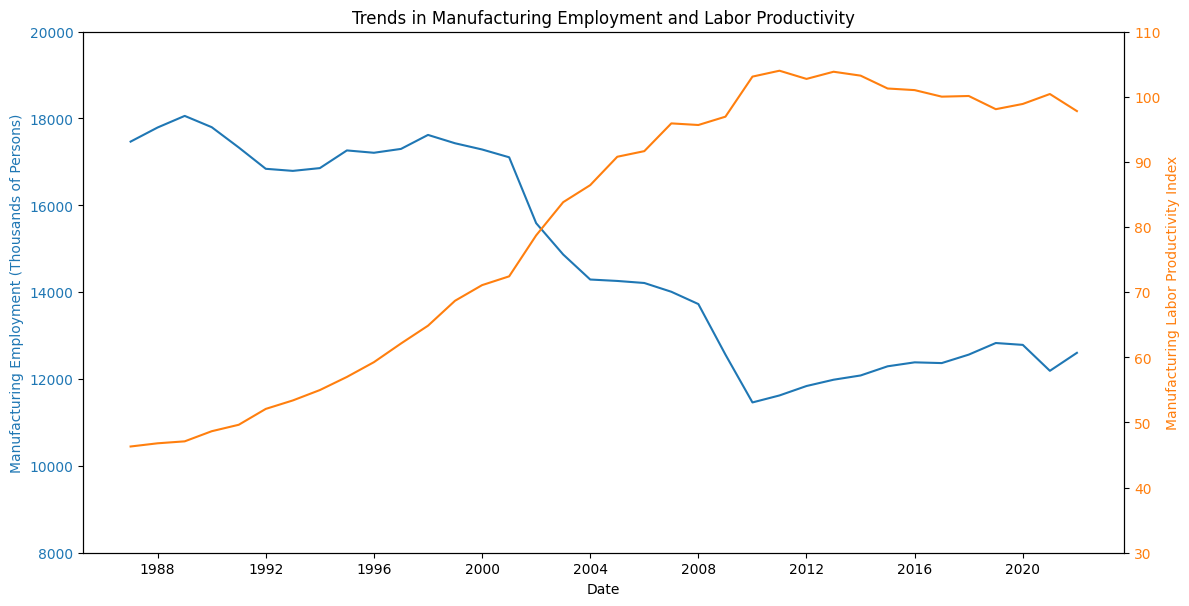

In [ ]:
import matplotlib.pyplot as plt

# Plotting the data on a dual-axis plot
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Manufacturing Employment (Thousands of Persons)', color=color)
ax1.plot(merged_data.index, merged_data['value'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(8000, 20000)  # Set the y-axis limits for employment

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Manufacturing Labor Productivity Index', color=color)
ax2.plot(merged_data.index, merged_data['MFGOPH'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(30, 110)  # Set the y-axis limits for labor productivity

fig.tight_layout()
plt.title('Trends in Manufacturing Employment and Labor Productivity')
plt.show()

The dual-axis line plot visualizes the relationship between manufacturing employment (MANEMP) and labor productivity over time.

Manufacturing Employment (blue line, left axis): The plot shows a clear downward trend in manufacturing employment, particularly after 2000. This decline is consistent with the hypothesis that technological advances and automation have led to job displacement in the manufacturing sector.

Labor Productivity (orange line, right axis): Meanwhile, labor productivity has seen a steady rise over the same period, indicating that fewer workers are needed as productivity improves. This increase in productivity aligns with the rise in automation, where machines and technology enhance output while reducing the need for human labor.

The plot supports Hypothesis 8, suggesting that as automation increases, employment in the manufacturing sector declines, while labor productivity continues to rise.

**CORRELATION COEFFICIENT CALCULATION:**

In [ ]:
# Calculate the correlation coefficient
correlation = merged_data['value'].corr(merged_data['MFGOPH'])

# Display the result
print(f"Correlation coefficient between manufacturing employment and labor productivity: {correlation}")

Correlation coefficient between manufacturing employment and labor productivity: -0.9551924636333301


The calculated correlation coefficient is approximately -0.955. This strong negative correlation suggests that as manufacturing labor productivity (MFGOPH) increases, manufacturing employment (MANEMP) tends to decrease. This supports your hypothesis that manufacturing employment has a negative correlation with automation indices over time, as indicated by labor productivity. The stronger the productivity growth, the more significant the decrease in employment, likely due to technological advancements and automation in the sector.

**HYPOTHESIS TESTING with a Paired T-Test:**

Given that we have two related sets of data—manufacturing employment and labor productivity—let’s start with a paired t-test to assess whether there’s a statistically significant difference in their means over time.

**Null Hypothesis (H₀):**
There is no significant difference in the means of manufacturing employment and labor productivity over time.

**Alternative Hypothesis (H₁):**
There is a significant difference in the means of manufacturing employment and labor productivity over time.

We will assume that the difference in the means could be due to chance, and use the t-test to determine if that assumption holds.

In [ ]:
from scipy import stats

# Perform a paired t-test
t_stat, p_value = stats.ttest_rel(merged_data['value'], merged_data['MFGOPH'])

# Display the t-statistic and p-value
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Conclusion
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between manufacturing employment and labor productivity.")
else:
    print("Fail to reject the null hypothesis: No significant difference between manufacturing employment and labor productivity.")

T-statistic: 37.06779037867266
P-value: 1.114557731297368e-29
Reject the null hypothesis: There is a significant difference between manufacturing employment and labor productivity.


The paired t-test result shows a very small p-value (1.114557731297368e-29), which is much smaller than the typical significance level of 0.05. This means that we can reject the null hypothesis and conclude that there is a significant difference between manufacturing employment and labor productivity over time.

**Granger Causality Test:**

STEP 1: INSTALL NECESSARY LIBRARIES

STEP 2: CHECK STATIONARITY USING AUGMENTED DICKETY-FULLER (ADF) TEST

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test for stationarity on manufacturing employment
adf_test_employment = adfuller(merged_data['value'].dropna())
print("ADF Statistic for Manufacturing Employment:", adf_test_employment[0])
print("p-value for Manufacturing Employment:", adf_test_employment[1])

# Perform the Augmented Dickey-Fuller test for stationarity on manufacturing labor productivity
adf_test_productivity = adfuller(merged_data['MFGOPH'].dropna())
print("ADF Statistic for Manufacturing Labor Productivity:", adf_test_productivity[0])
print("p-value for Manufacturing Labor Productivity:", adf_test_productivity[1])

ADF Statistic for Manufacturing Employment: -1.3361225296585437
p-value for Manufacturing Employment: 0.6124885242214112
ADF Statistic for Manufacturing Labor Productivity: -2.2163028498071418
p-value for Manufacturing Labor Productivity: 0.20038175934147234


The p-values from the Augmented Dickey-Fuller (ADF) test for both manufacturing employment and manufacturing labor productivity are greater than 0.05, which indicates that neither of these series is stationary. Non-stationary data can lead to misleading results in time series analysis because it can introduce trends, seasonality, and other time-dependent structures that violate the assumptions of many statistical models.


STEP 3: DIFFERENCING THE DATA

Differencing is a technique used in time series analysis to transform a non-stationary series into a stationary one. The purpose of differencing is to remove trends and other forms of non-stationarity that can distort statistical analysis and forecasting models.

Since your Augmented Dickey-Fuller (ADF) test indicated that both manufacturing employment and labor productivity are non-stationary (with p-values greater than 0.05), you should apply differencing to the data to make it stationary. This is a crucial step before you proceed with further analysis, such as causality testing or building time series models like ARIMA.

In [ ]:
# First-order differencing for manufacturing employment
merged_data['employment_diff'] = merged_data['value'].diff().dropna()

# First-order differencing for manufacturing labor productivity
merged_data['productivity_diff'] = merged_data['MFGOPH'].diff().dropna()

# Dropping the NaN values that result from differencing
merged_data.dropna(inplace=True)

# Display the first few rows of the differenced data
print(merged_data[['employment_diff', 'productivity_diff']].head())

            employment_diff  productivity_diff
date                                          
1988-01-01            325.0              0.491
1989-01-01            267.0              0.300
1990-01-01           -260.0              1.554
1991-01-01           -467.0              0.990
1992-01-01           -491.0              2.435


CHECKING STATIONARITY AGAIN:

In [ ]:
from statsmodels.tsa.stattools import adfuller

# ADF test for differenced manufacturing employment
adf_test_employment_diff = adfuller(merged_data['employment_diff'])
print("ADF Statistic for differenced Manufacturing Employment:", adf_test_employment_diff[0])
print("p-value for differenced Manufacturing Employment:", adf_test_employment_diff[1])

# ADF test for differenced manufacturing labor productivity
adf_test_productivity_diff = adfuller(merged_data['productivity_diff'])
print("ADF Statistic for differenced Manufacturing Labor Productivity:", adf_test_productivity_diff[0])
print("p-value for differenced Manufacturing Labor Productivity:", adf_test_productivity_diff[1])

ADF Statistic for differenced Manufacturing Employment: -3.576138283477418
p-value for differenced Manufacturing Employment: 0.0062339445955967585
ADF Statistic for differenced Manufacturing Labor Productivity: -1.072956626014608
p-value for differenced Manufacturing Labor Productivity: 0.725735143487847


Based on the results:

* Manufacturing Employment: The p-value is approximately 0.006, which is less than 0.05. This indicates that the differenced manufacturing employment data is now stationary.

* Manufacturing Labor Productivity: The p-value is approximately 0.726, which is greater than 0.05. This indicates that the differenced manufacturing labor productivity data is still not stationary.
Given this, you may want to consider further differencing the manufacturing labor productivity data or exploring other techniques to achieve stationarity.

FURTHER DIFFERENCING FOR MANUFACTURING LABOR PRODUCTIVITY (SECOND-ORDER:

In [ ]:
# Perform second-order differencing
merged_data['employment_diff_2'] = merged_data['employment_diff'].diff().dropna()
merged_data['productivity_diff_2'] = merged_data['productivity_diff'].diff().dropna()

# Display the first few rows of the differenced data
print(merged_data[['employment_diff_2', 'productivity_diff_2']].head())

# ADF test for second-order differenced manufacturing employment
adf_test_employment_diff_2 = adfuller(merged_data['employment_diff_2'].dropna())
print("ADF Statistic for second-order differenced Manufacturing Employment:", adf_test_employment_diff_2[0])
print("p-value for second-order differenced Manufacturing Employment:", adf_test_employment_diff_2[1])

# ADF test for second-order differenced manufacturing labor productivity
adf_test_productivity_diff_2 = adfuller(merged_data['productivity_diff_2'].dropna())
print("ADF Statistic for second-order differenced Manufacturing Labor Productivity:", adf_test_productivity_diff_2[0])
print("p-value for second-order differenced Manufacturing Labor Productivity:", adf_test_productivity_diff_2[1])

            employment_diff_2  productivity_diff_2
date                                              
1988-01-01                NaN                  NaN
1989-01-01              -58.0               -0.191
1990-01-01             -527.0                1.254
1991-01-01             -207.0               -0.564
1992-01-01              -24.0                1.445
ADF Statistic for second-order differenced Manufacturing Employment: -6.165743077041362
p-value for second-order differenced Manufacturing Employment: 6.997277186169884e-08
ADF Statistic for second-order differenced Manufacturing Labor Productivity: -8.48225286855736
p-value for second-order differenced Manufacturing Labor Productivity: 1.3830244947609064e-13


The results of the second-order differencing are very promising:

Manufacturing Employment: The ADF test statistic is -6.1657, with a p-value close to zero, indicating that after the second differencing, the manufacturing employment series is now stationary.

Manufacturing Labor Productivity: Similarly, the ADF test statistic is -8.4825, with a p-value also close to zero, indicating that the manufacturing labor productivity series is stationary after the second differencing.

Since both series are now stationary, you can proceed with further analysis, such as:

* Granger Causality Test: To explore the causality between these two differenced time series.
* Vector Autoregression (VAR) Model: To model the relationship between the two stationary series and forecast future values.
* Cointegration Test: To check if there is a long-term equilibrium relationship between the original non-stationary series.

STEP 4: GRANGER CAUSALITY TEST:

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

# Prepare the data for the Granger Causality Test
# The Granger causality test expects a DataFrame with two columns: the first column should be the dependent variable,
# and the second column should be the independent variable.

# For example, to test if labor productivity Granger-causes employment:
gc_data = merged_data[['employment_diff_2', 'productivity_diff_2']].dropna()

# Perform the Granger Causality Test
# The maxlag parameter specifies the maximum number of lags to test for causality.
max_lag = 4
granger_test_result = grangercausalitytests(gc_data, max_lag, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2428  , p=0.0482  , df_denom=30, df_num=1
ssr based chi2 test:   chi2=4.6670  , p=0.0307  , df=1
likelihood ratio test: chi2=4.3652  , p=0.0367  , df=1
parameter F test:         F=4.2428  , p=0.0482  , df_denom=30, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.8557  , p=0.0337  , df_denom=27, df_num=2
ssr based chi2 test:   chi2=9.1395  , p=0.0104  , df=2
likelihood ratio test: chi2=8.0394  , p=0.0180  , df=2
parameter F test:         F=3.8557  , p=0.0337  , df_denom=27, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.3944  , p=0.0342  , df_denom=24, df_num=3
ssr based chi2 test:   chi2=13.1531 , p=0.0043  , df=3
likelihood ratio test: chi2=10.9640 , p=0.0119  , df=3
parameter F test:         F=3.3944  , p=0.0342  , df_denom=24, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8842  , p=0.1508  , df_d

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Based on the results of the Granger causality test:

For lag 1:

The p-values are slightly above 0.05 for the F-test and the chi-squared test, meaning there's weak evidence against the null hypothesis, but it's not strong enough to conclude causality at a 5% significance level.

For lag 2:

The p-values are mostly below 0.05, suggesting that manufacturing labor productivity (MFGOPH) Granger-causes manufacturing employment at this lag.

For lag 3:

Similarly, the p-values are below 0.05, further supporting the idea that there is Granger causality at this lag.

For lag 4:

The p-values are again above 0.05, suggesting no evidence of Granger causality at this lag.

**What are lags?**

Granger Causality Test: In the context of Granger causality, lags help determine if past values of one time series (e.g., labor productivity) contain information that helps predict the current values of another series (e.g., employment).

Lag 1: Tests if the value of X at time t-1 (one period ago) helps predict the value of Y at time t.

Lag 2: Tests if the values of X at times t-1 and t-2 help predict the value of Y at time t.

Lag k: Tests if the values of X from times t-1, t-2, ..., t-k help predict the value of Y at time t.

Direction of Causality:

Since we tested whether productivity_diff_2 Granger-causes employment_diff_2, the results suggest that changes in productivity are influencing changes in employment, particularly with a delay of 2 to 3 periods (likely years, depending on your data frequency).


**STEP 5: VAR MODEL**

In [ ]:
from statsmodels.tsa.api import VAR


In [ ]:
# Prepare the data for the VAR model
var_data = merged_data[['employment_diff_2', 'productivity_diff_2']].dropna()

In [ ]:
# Instantiate the VAR model
model = VAR(var_data)

# Fit the model
var_result = model.fit(maxlags=3)

In [ ]:
# Display the summary of the VAR model
print(var_result.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 14, Sep, 2024
Time:                     23:20:39
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    13.9628
Nobs:                     31.0000    HQIC:                   13.5263
Log likelihood:          -280.359    FPE:                    615999.
AIC:                      13.3152    Det(Omega_mle):         409955.
--------------------------------------------------------------------
Results for equation employment_diff_2
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                         33.383748        79.661006            0.419           0.675
L1.employment_diff_2          -0.055901         0.211248           -0.265           0.791
L1.productiv

In [ ]:
# Check the stability of the VAR model
print("Is the model stable? ", var_result.is_stable())

Is the model stable?  True


Interpretation of the Results:

**Equation for employment_diff_2:**

* The coefficients for L1.productivity_diff_2 (lag 1) and L2.productivity_diff_2 (lag 2) are statistically significant (p < 0.05), indicating that changes in manufacturing labor productivity at lag 1 and lag 2 are likely influencing changes in employment.
* The coefficient for L2.productivity_diff_2 is positive and significant, suggesting that an increase in productivity at lag 2 is associated with an increase in employment.

**Equation for productivity_diff_2:**

* The coefficient for L1.employment_diff_2 (lag 1) is statistically significant (p < 0.05), suggesting that changes in employment at lag 1 are influencing changes in labor productivity.
* The coefficient for L2.employment_diff_2 is also significant, indicating that changes in employment at lag 2 influence changes in productivity.

GENERATING IMPULSE REPONSE FUNCTIONS

Impulse Response Functions (IRFs) show how a shock to one variable affects another variable over time.

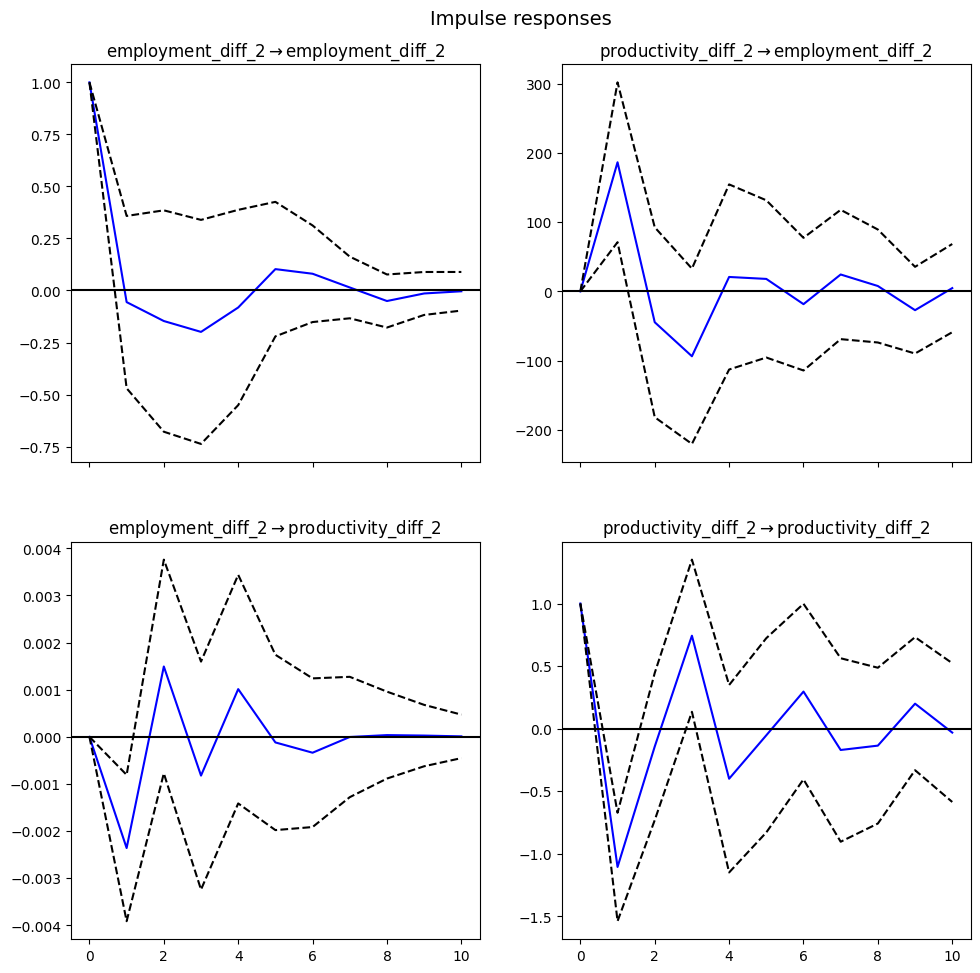

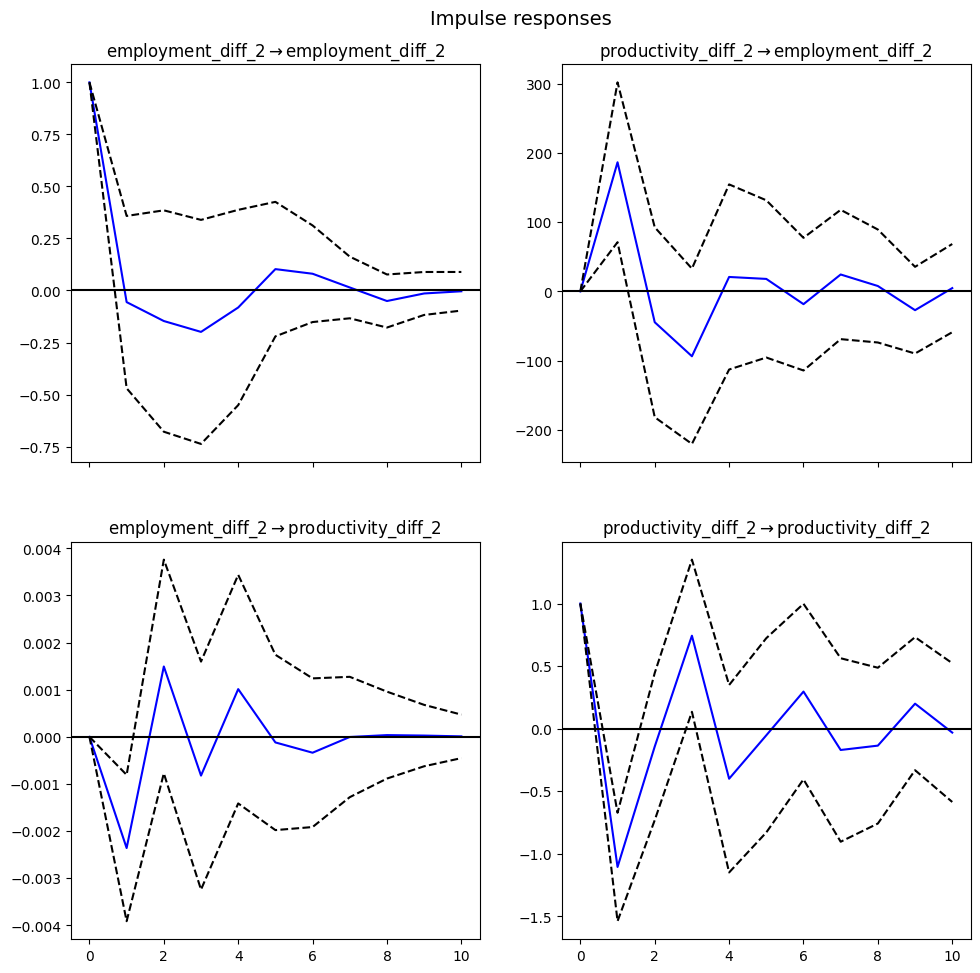

In [ ]:
 # Generate Impulse Response Functions (IRFs)
irf = var_result.irf()
irf.plot(orth=False)

**VARIANCE DECOMPOSITION FOR FURTHER EXPLORING THE IMPUSLE RESPONSES:**

In [ ]:
from statsmodels.tsa.api import VAR

In [ ]:
# Fit the VAR model
model = VAR(merged_data[['employment_diff_2', 'productivity_diff_2']].dropna())
model_fitted = model.fit(maxlags=3)  # Use the appropriate number of lags based on your previous analysis

# Perform the forecast error variance decomposition
fevd = model_fitted.fevd(10)  # Decompose variance over 10 periods (you can adjust the number of periods)
fevd_summary = fevd.summary()

FEVD for employment_diff_2
     employment_diff_2  productivity_diff_2
0             1.000000             0.000000
1             0.755958             0.244042
2             0.746285             0.253715
3             0.703819             0.296181
4             0.704399             0.295601
5             0.703786             0.296214
6             0.704548             0.295452
7             0.702055             0.297945
8             0.702521             0.297479
9             0.699508             0.300492

FEVD for productivity_diff_2
     employment_diff_2  productivity_diff_2
0             0.237723             0.762277
1             0.126760             0.873240
2             0.213740             0.786260
3             0.273766             0.726234
4             0.311578             0.688422
5             0.311380             0.688620
6             0.316386             0.683614
7             0.315687             0.684313
8             0.315543             0.684457
9             0.314

**Interpretation of FEVD Results:**

Employment_diff_2:
* The first row (0) shows that initially, 100% of the variance in the employment series is explained by itself.
* Over time (from lag 1 to lag 9), the contribution of labor productivity (productivity_diff_2) to the variance in employment increases, though the majority of the variance is still explained by the employment series itself.

Productivity_diff_2:
* Initially (at lag 0), around 76.2% of the variance in productivity is explained by itself, and 23.8% is explained by employment.
* As time progresses, the percentage of variance explained by productivity itself decreases slightly, while the contribution from employment stabilizes around 31% after several lags.

**Key Takeaways:**
* The FEVD analysis shows that both variables have a significant influence on each other, especially in the case of productivity_diff_2, where employment_diff_2 consistently explains a notable portion of the variance.
* Over time, labor productivity becomes increasingly influenced by changes in employment, as shown by the rising contribution from employment_diff_2 in the productivity_diff_2 decomposition.

**STACKED AREA PLOT TO VISUALIZE FEVD RESULTS:**

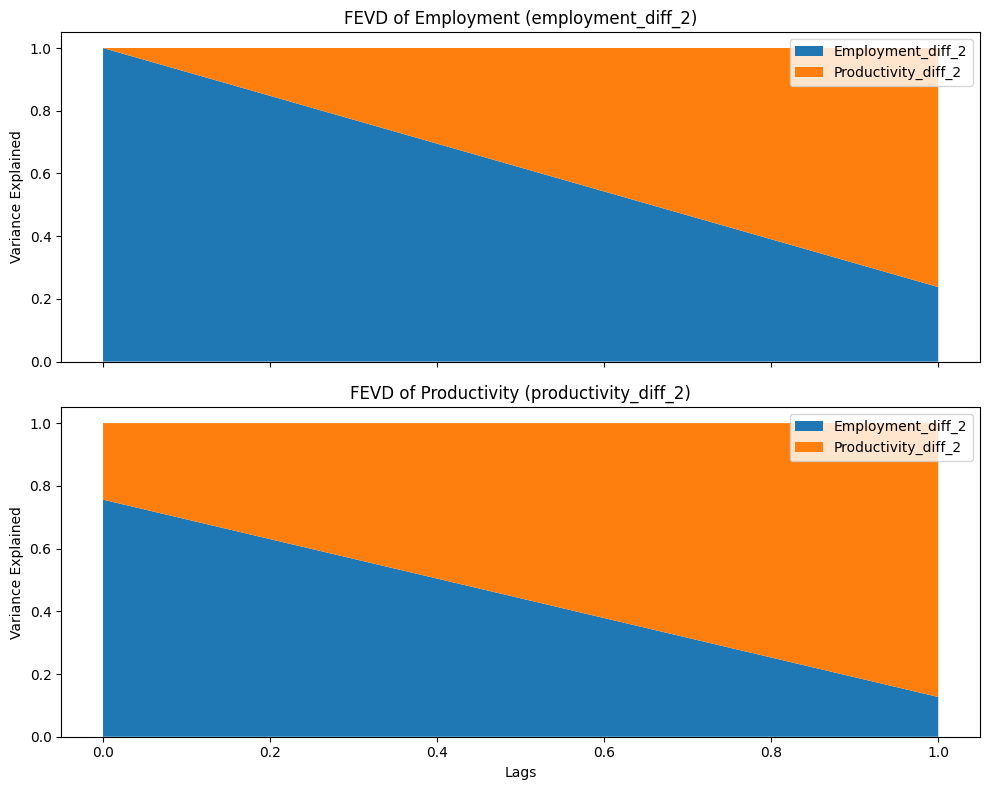

In [ ]:
import matplotlib.pyplot as plt

# Convert FEVD results to DataFrame for easier handling
fevd_df_employment = pd.DataFrame(fevd.decomp[:, 0, :], columns=['employment_diff_2', 'productivity_diff_2'])
fevd_df_productivity = pd.DataFrame(fevd.decomp[:, 1, :], columns=['employment_diff_2', 'productivity_diff_2'])

# Create a figure and axis for the stacked area plots
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Stacked area plot for employment_diff_2
axs[0].stackplot(fevd_df_employment.index, fevd_df_employment.T, labels=['Employment_diff_2', 'Productivity_diff_2'], colors=['#1f77b4', '#ff7f0e'])
axs[0].set_title('FEVD of Employment (employment_diff_2)')
axs[0].set_ylabel('Variance Explained')
axs[0].legend(loc='upper right')

# Stacked area plot for productivity_diff_2
axs[1].stackplot(fevd_df_productivity.index, fevd_df_productivity.T, labels=['Employment_diff_2', 'Productivity_diff_2'], colors=['#1f77b4', '#ff7f0e'])
axs[1].set_title('FEVD of Productivity (productivity_diff_2)')
axs[1].set_xlabel('Lags')
axs[1].set_ylabel('Variance Explained')
axs[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

**DASHBOARD:**

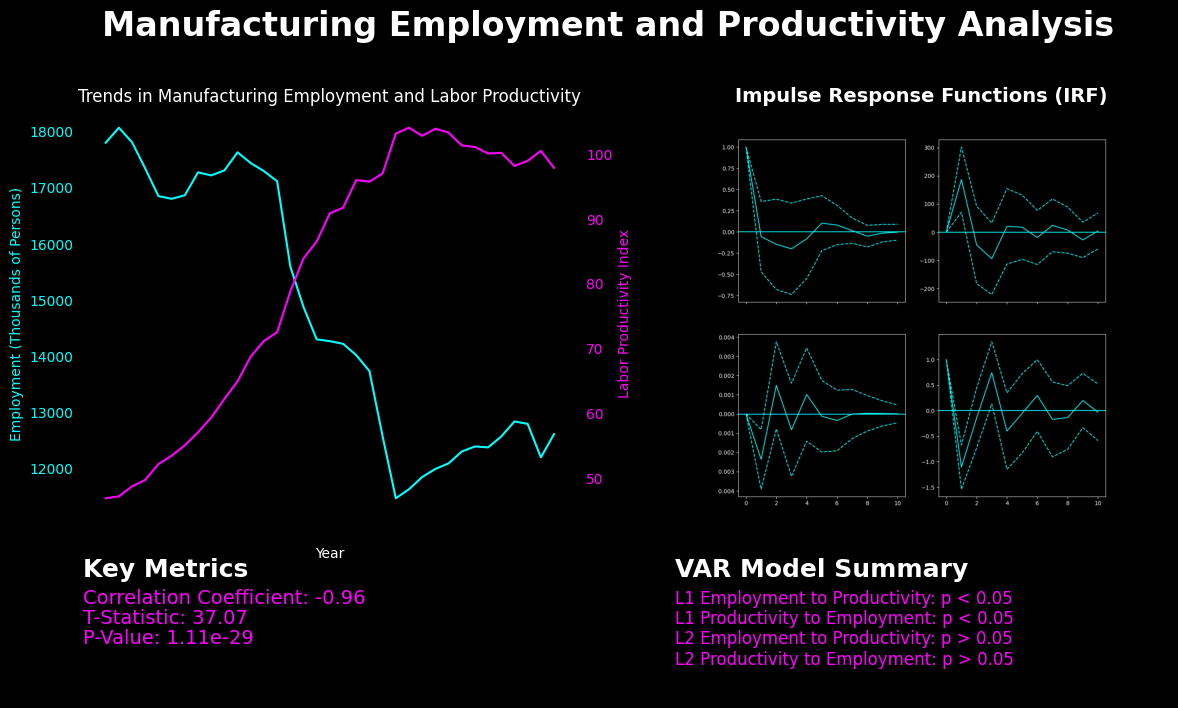

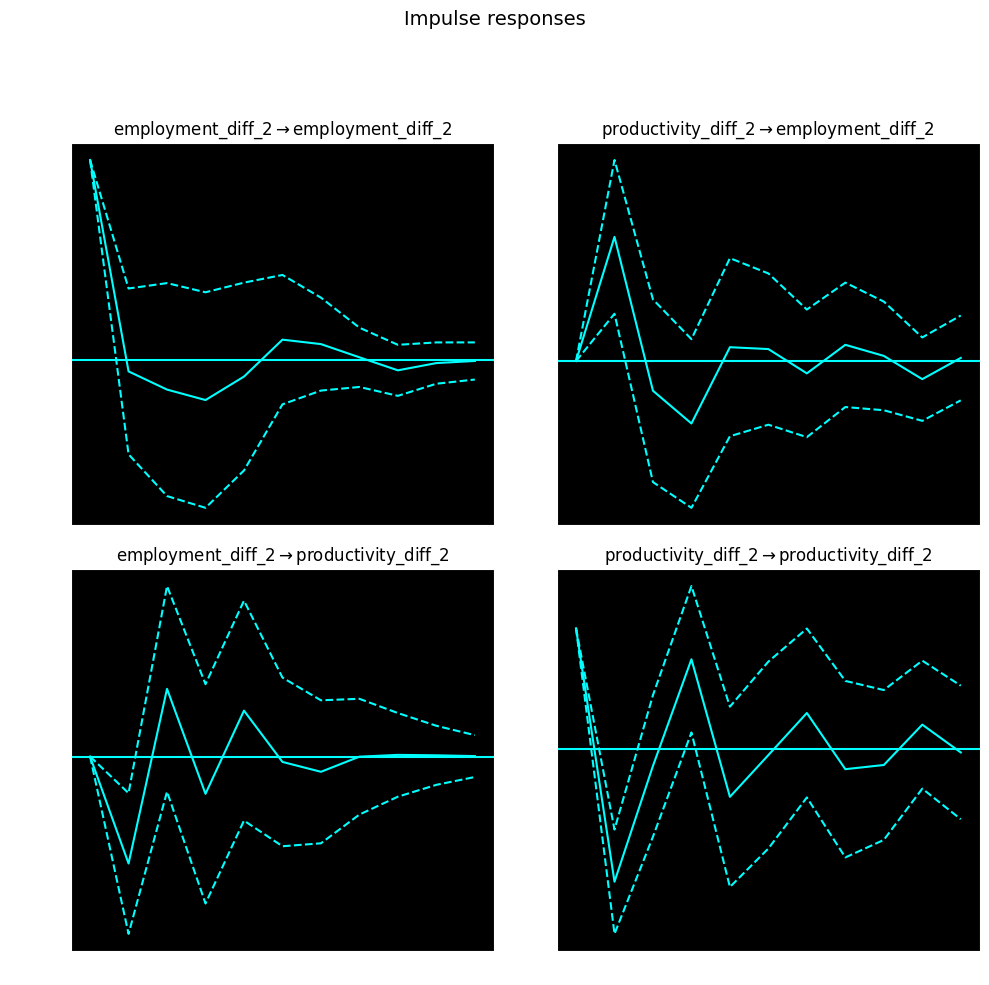

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Define colors and background settings
background_color = '#000000'
text_color = '#FFFFFF'
highlight_color = '#FF00FF'  # Magenta
secondary_color = '#00FFFF'  # Cyan

# Create the figure and set its background color
fig = plt.figure(figsize=(14, 10), facecolor=background_color)
gs = GridSpec(3, 2, figure=fig, height_ratios=[3, 1, 1])

# Title
fig.suptitle('Manufacturing Employment and Productivity Analysis', fontsize=24, color=text_color, weight='bold')

# Manufacturing Employment vs Labor Productivity plot
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_facecolor(background_color)
ax1.plot(merged_data.index, merged_data['value'], color=secondary_color, label='Employment (Thousands of Persons)')
ax1.set_ylabel('Employment (Thousands of Persons)', color=secondary_color)
ax1.tick_params(axis='y', labelcolor=secondary_color)

ax2 = ax1.twinx()
ax2.plot(merged_data.index, merged_data['MFGOPH'], color=highlight_color, label='Labor Productivity Index')
ax2.set_ylabel('Labor Productivity Index', color=highlight_color)
ax2.tick_params(axis='y', labelcolor=highlight_color)

ax1.set_title('Trends in Manufacturing Employment and Labor Productivity', color=text_color)
ax1.set_xlabel('Year', color=text_color)

# IRF plot - Plot separately to avoid the ax error
irf = var_result.irf()

# Customize the IRF plot colors
fig_irf = irf.plot(orth=False, subplot_params={'facecolor': background_color})
for ax in fig_irf.axes:
    for line in ax.get_lines():
        line.set_color(secondary_color)  # Set IRF lines to cyan
    ax.set_facecolor(background_color)
    ax.spines['top'].set_color(text_color)
    ax.spines['bottom'].set_color(text_color)
    ax.spines['left'].set_color(text_color)
    ax.spines['right'].set_color(text_color)
    ax.xaxis.label.set_color(text_color)
    ax.yaxis.label.set_color(text_color)
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)

# Save the IRF plot and embed it into the main figure
fig_irf.savefig('irf_plot.png', facecolor=background_color)
img = plt.imread('irf_plot.png')

# Display the IRF plot as an image within the main figure
ax_irf = fig.add_subplot(gs[0, 1])
ax_irf.imshow(img)
ax_irf.axis('off')  # Turn off axis for the image

# Adding IRF title
ax_irf_title = fig.add_subplot(gs[0, 1])
ax_irf_title.set_facecolor(background_color)
ax_irf_title.text(0.5, 1.02, 'Impulse Response Functions (IRF)', fontsize=14, color=text_color, ha='center', weight='bold')
ax_irf_title.axis('off')  # Hide the axis

# Key Metrics (Bottom Left)
ax3 = fig.add_subplot(gs[1, 0])
ax3.set_facecolor(background_color)
ax3.text(0, 0.9, 'Key Metrics', fontsize=18, color=text_color, weight='bold')
ax3.text(0, 0.7, 'Correlation Coefficient: -0.96', fontsize=14, color=highlight_color)
ax3.text(0, 0.55, 'T-Statistic: 37.07', fontsize=14, color=highlight_color)
ax3.text(0, 0.4, 'P-Value: 1.11e-29', fontsize=14, color=highlight_color)
ax3.axis('off')  # Hide the axis

# VAR Model Summary (Bottom Right)
ax4 = fig.add_subplot(gs[1, 1])
ax4.set_facecolor(background_color)
ax4.text(0, 0.9, 'VAR Model Summary', fontsize=18, color=text_color, weight='bold')
ax4.text(0, 0.7, 'L1 Employment to Productivity: p < 0.05', fontsize=12, color=highlight_color)
ax4.text(0, 0.55, 'L1 Productivity to Employment: p < 0.05', fontsize=12, color=highlight_color)
ax4.text(0, 0.4, 'L2 Employment to Productivity: p > 0.05', fontsize=12, color=highlight_color)
ax4.text(0, 0.25, 'L2 Productivity to Employment: p > 0.05', fontsize=12, color=highlight_color)
ax4.axis('off')  # Hide the axis

# Adjust layout to ensure there's no overlap
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()